In [174]:
import sys, os
import numpy as np
from pyhdf.SD import SD
import pandas as pd
from datetime import datetime, time, timedelta
import re

# Path and Variable declarations
# External harddrive path
#file_ext= "D:\\NASAdataSocorroHueco"

# Internal testing folder
file_ext=r"C:\Users\Zelda64\Documents\Programming\dust_solar_power\AIRS"
#sort file list
file_list=sorted(os.listdir(file_ext)[1:])
test_list=file_list[:1]
test_list

# File names for TECQ PM2.5 stations in West Texas
file_name_cams49=r'CAMS_49_SocorroHueco.xlsx'
file_name_cams1028=r'CAMS_1028_Lubbock.xlsx'

# Coordinates for TECQ stations
CAMS49 = [31.6676,-106.288]
CAMS1028 = [33.5856, -101.78]

# Array of matched PM to dust_score
dust_score_pm_matches=[]

In [175]:

def read_xlsx_tecq(file_name):
    """
    Function for reading xlsx TECQ file in the same file path as the jupyter notebook
    Dataframe elements are coerced to numeric, leaving NaN values present
    The 'Date' columns is set as the index, this helps to search rows by datetime later
    Row indices and column headers are datetime objects

    Parameters:
        files_name (str): name of file
    """
    tecq_df=pd.read_excel(os.path.join(sys.path[0],file_name))
    for col in tecq_df.columns[1:]:
        tecq_df[col]=pd.to_numeric(tecq_df[col], errors='coerce')
    tecq_df.set_index('Date', inplace=True)
    return tecq_df
    
# Read both TECQ files into dataframes
tecq_cams49 = read_xlsx_tecq(file_name_cams49)
tecq_cams1028= read_xlsx_tecq(file_name_cams1028)
#tecq_cams49.info()
tecq_cams49
tecq_cams1028

,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,4.0,5.0,2.0,3.0,4.0,3.0,3.0,7.0,2.0,3.0,...,0.0,6.0,4.0,3.0,3.0,3.0,1.0,2.0,2.0,4.0
2019-01-02,-1.0,3.0,2.0,2.0,4.0,2.0,4.0,6.0,1.0,7.0,...,3.0,8.0,4.0,8.0,12.0,10.0,8.0,7.0,7.0,10.0
2019-01-03,10.0,16.0,12.0,9.0,7.0,6.0,6.0,6.0,2.0,6.0,...,0.0,3.0,2.0,4.0,3.0,5.0,4.0,1.0,2.0,2.0
2019-01-04,-2.0,2.0,0.0,-3.0,-1.0,-3.0,1.0,0.0,-4.0,2.0,...,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,6.0,3.0,7.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,1.3,1.3,4.9,8.0,5.5,8.0,3.7,6.0,8.1,9.2,...,3.3,1.4,1.3,1.3,1.3,9.5,3.8,9.7,5.7,8.9
2019-12-28,9.3,10.2,2.9,6.8,4.5,6.1,6.3,-0.1,0.2,-0.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [176]:
def coordinates(lat,long):
    """
    Function takes separate latitude and longitude values from the arrays present in the AIRS hdf file and combines them into one lat, long point
    
    Parameters:
        lat,long (list): separate coordinate points
    """
    #create multidimensional array with same dimensions as lat and long arrays in hdf file
    coords=np.zeros((lat.shape[0],lat.shape[1],2),dtype='float')
    for i in range(lat.shape[0]):
        for j in range(lat.shape[1]):
            #create an array from lat long points before saving into coords array
            coords[(i,j)]=np.array([lat[i,j],long[i,j]])        
    return coords

In [177]:
def round_nearest_hour(datetime_obj):
    """
    Function takes a datetime object and rounds up or down to nearest hour

    Parameters:
        datetime_obj (datetime): datetime object
    """
    start_hour = datetime_obj.replace(minute=0, second=0, microsecond=0)
    half_hour = datetime_obj.replace(minute=30, second=0, microsecond=0)
    #rounding up or down 
    if datetime_obj >= half_hour:
        datetime_obj = start_hour + datetime.timedelta(hours=1)
    else:
        datetime_obj = start_hour
    return datetime_obj

In [178]:
def find_productiondatetime(global_attributes):
    # Regex for PRODUCTIONDATETIME YYYY-MM-DD pattern
    datetime_pattern = r'VALUE="\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d{3}Z"'  
    
    core_attributes=global_attributes.get('coremetadata')
    core_attributes_groups=core_attributes.split('\n')
    core_attributes_groups_whitespace = [element.strip() for element in core_attributes_groups]
    core_attributes_groups_strspace = [element.replace(' ', '') for element in core_attributes_groups_whitespace]

    # Search for strings that match the datetime pattern in the index
    # There should be only one match
    matches = [string for string in core_attributes_groups_strspace if re.match(datetime_pattern, string)][0]
    # Find the PRODUCTIONDATETIME of the HDF file
    datetime_hdf_raw=matches.split('=')[1].strip('"')
            
            
    return datetime_hdf_raw

In [179]:
def match_coords(coords, array_to_match):
    matched_coords=np.zeros((coords.shape[0],coords.shape[1],coords.shape[2]),bool)
    for i in range(len(coords[:])):
        for j in range(len(coords[0,:])):
            matched_coords[i,j] = np.isclose(coords[i,j],array_to_match,rtol=0.02)
            if np.all(matched_coords[i,j] == [False, True]) or np.all(matched_coords[i,j] == [True, False]):
                matched_coords[i,j]=[False, False]
    return matched_coords
    
def create_mask(matched_coords):
    mask=np.zeros((matched_coords.shape[0],matched_coords.shape[1]),bool)
    for i in range(len(matched_coords[:])):
        for j in range(len(matched_coords[0,:])):
            if np.all(matched_coords[i,j] == [True, True]):
                mask[i,j]=[True]
    return mask

In [180]:
def open_hdf4_files(file_list: list):
    """
    Open list of AIRS HDF4 files and read dust_score, latitude, longitude and run 
    other functions to work with them.
    
    Parameters:
        file_list (list): List of file paths to HDF4 files.
    """
    for file in file_list:
        file_path=os.path.join(file_ext,file)
        print("Opening file:", file_path)
        try:
            hdf_file = SD(file_path)
            # Print information about the HDF4 file
            print("File Info:")
            print(hdf_file.info())
            # Select dust_score, lat and long     
            dust_score=hdf_file.select('dust_score')[:]
            long=hdf_file.select('Longitude')[:]
            lat=hdf_file.select('Latitude')[:]
            coords=coordinates(lat,long)
            # Find timestamp of production
            global_attributes = hdf_file.attributes()
            # Get raw productiondatetime from hdf file
            datetime_hdf_raw=find_productiondatetime(global_attributes)
            # Convert raw string into datetime object
            datetime_converted=datetime.strptime(datetime_hdf_raw,"%Y-%m-%dT%H:%M:%S.%fZ")
            # Convert datetime object (date part only) into string
            datetime_converted_str=datetime_converted.date().strftime("%Y-%m-%d")
            # Use the date string to find the matching date row in the TECQ file
            tecq_date_found=tecq_cams49.loc[datetime_converted_str]

            '''
            Currently only checking CAMS49 station
            '''
            # Round time from converted hdf datetime object to nearest hour 
            datetime_rounded_time=round_nearest_hour(datetime_converted)
            # Make an array of an hour before and after the flyby's rounded hour
            datetime_range=[(datetime_rounded_time-timedelta(hours=1)).time(), (datetime_rounded_time.time()), (datetime_rounded_time+timedelta(hours=1)).time()]
            # Find the mean PM concentration at time of satellite flyby at TECQ station
            tecq_pm_hourmean_cams49=np.mean(tecq_date_found[datetime_range])
            print(tecq_pm_hourmean_cams49)

            # Find the dust_score mean at TECQ station's location
            array_to_match=[CAMS49[0],CAMS49[1]]
            matched_coords=match_coords(coords, array_to_match)
            mask=create_mask(matched_coords)
            
            dust_score_masked=dust_score[mask]
            coords_masked=coords[mask]
            dust_score_mean=np.mean(dust_score_masked)
            print(dust_score_mean)

            dust_score_pm_tuple=[tecq_pm_hourmean_cams49, dust_score_mean]
            dust_score_pm_matches.append(dust_score_pm_tuple)
            print(dust_score_pm_matches)
            print("\n")
            # Close the HDF4 file
            #hdf_file.end()
        except Exception as e:
            print("Error opening file:", file_path)
            print(e)
            print("\n")
    return coords, dust_score     
if __name__ == "__main__":

    # Open HDF4 files
    coords, dust_score=open_hdf4_files(test_list)
    

Opening file: C:\Users\Zelda64\Documents\Programming\dust_solar_power\AIRS\AIRS.2019.01.01.208.L1B.AIRS_Rad.v5.0.23.0.G19002102412.hdf
File Info:
(77, 4)
5.3
260.65555555555557
[[5.3, 260.65555555555557]]




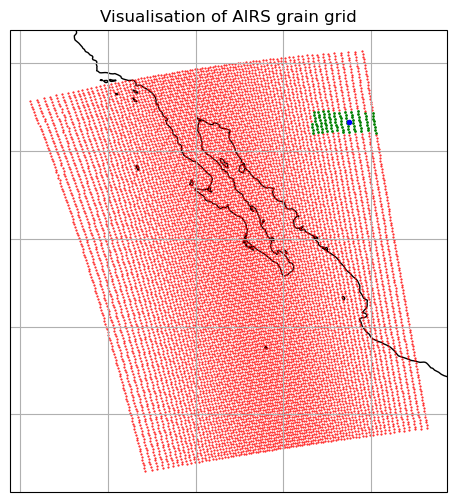

In [136]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Create a map plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Plot each coordinate on the map
for elem in coords[:]:
    for point in elem:
        lat,long=point[0],point[1]
        if np.any(point==coords_masked):
            ax.plot(long, lat, 'go', markersize=1, transform=ccrs.PlateCarree())
        else:
            ax.plot(long, lat, 'r.', markersize=1, transform=ccrs.PlateCarree())
    
ax.plot(CAMS49[1],CAMS49[0], 'bo', markersize=3, transform=ccrs.PlateCarree())
# Add gridlines and coastlines
ax.gridlines()
ax.coastlines()

# Add title and show the plot
plt.title('Visualisation of AIRS grain grid')
plt.show()



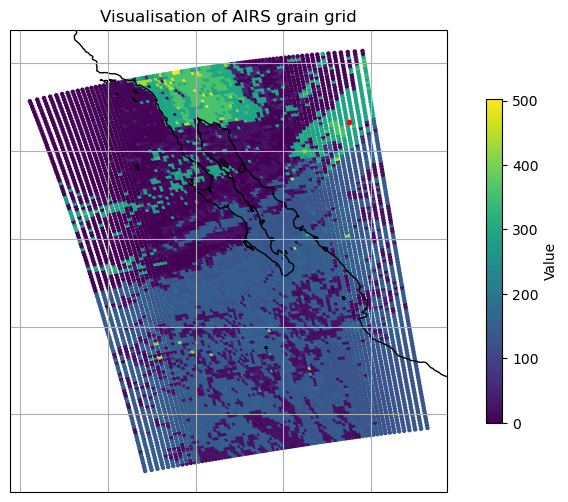

In [132]:
from matplotlib.colors import Normalize

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

lats=coords[:,:,0]
longs=coords[:,:,1]
# Plot each coordinate on the map
sc = ax.scatter(longs, lats, c=dust_score, cmap='viridis', norm=Normalize(vmin=dust_score.min(), vmax=dust_score.max()), s=5, transform=ccrs.PlateCarree())
cbar = fig.colorbar(sc, ax=ax, orientation='vertical', shrink=0.7)
cbar.set_label('Value')
ax.plot(CAMS49[1],CAMS49[0], 'ro', markersize=3, transform=ccrs.PlateCarree())
# Add gridlines and coastlines
ax.gridlines()
ax.coastlines()

# Add title and show the plot
plt.title('Visualisation of AIRS grain grid')
plt.show()


